## Sentiment analysis of stock market using twitter

## Importing library

In [22]:
# !pip install seaborn
# !pip install yfinance
# !pip install pandas_ta

import pandas as pd
import pandas_ta as ta
import seaborn as sns
from pandas import DataFrame
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

## Getting stock and ETF data

In [2]:
# use this func with the input as " ":Example: indicators("AAPL")
def indicators(ticker_symbol):
    df1 = yf.Ticker(f'{ticker_symbol}').history(period="max", interval = "1h",start="2018-12-31", end="2019-12-30")
    df2 = yf.Ticker(f'{ticker_symbol}').history(period="max", interval = "1h",start="2019-12-31", end="2020-12-14")
    df = pd.concat([df1,df2],axis=0)
    df.ta.sma(length=20, append=True)
    df.ta.sma(length=50, append=True)
    df.ta.sma(length=100, append=True)
    df.ta.ema(close=df.ta.ohlc4(append=True), length=20, append=True)
    df.ta.ema(close=df.ta.ohlc4(append=True), length=50, append=True)
    df.ta.ema(close=df.ta.ohlc4(append=True), length=100, append=True)
    df.ta.rsi(append=True)
    df.ta.cci(append=True)
    df.ta.zscore(append=True)
#     df = pd.concat([df,rsi,macd,cci,zscore],axis=1)
    df.rename(columns={"CCI_14_0.015":"CCI","open":"Open"},inplace=True)
    return df

def without(ticker_symbol):
    spy1 = yf.Ticker(f'{ticker_symbol}').history(period="max", interval = "1h",start="2018-12-31", end="2019-12-30")
    spy2 = yf.Ticker(f'{ticker_symbol}').history(period="max", interval = "1h",start="2019-12-31", end="2020-12-14")
    spy = pd.concat([spy1,spy2],axis=0)
    return spy
 


## Cleaning data - getting activehours data

In [3]:
def transforming(df):
    df["date"] = df.index
    gropu = (df.groupby(df["date"]).count())
    holiday = gropu[ gropu["Open"] < 7 ] # Step 1
    act = gropu.drop(holiday.index, axis=0)
    active = df.drop(holiday.index, axis=0) # Step 2
    days = int(active.shape[0]/7)
    hr = [1,2,3,4,5,6,7]
    hr = hr*days
    hr_pd = DataFrame(hr,columns = ["hour"])
    active.reset_index(drop=True, inplace=True)
    active_hr = pd.concat([hr_pd, active], axis = 1)
    return active_hr

In [4]:
def stock(ticker):
    x = indicators(f'{ticker}')
    y = transforming(x)
    return y

In [5]:
def etf(ticker):
    x = without(f'{ticker}')
    y = transforming(x)
    return y


## Creating SQL Database

In [6]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = ON")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


## Creating SQL tables

In [7]:
from datetime import datetime
conn1 = create_connection('stock_analysis.db',delete_db=True)


with conn1:
    

    
    
    create_table_sql_stock="""CREATE TABLE [stockDB] (hour REAl not null,Open REAl,high REAl, low REAl,close REAl, volume REAl
    ,Dividends REAl ,Stock_Splits REAl,SMA_20 REAl, 
    SMA_50 REAl, SMA_100 REAl, OHLC4 REAl, EMA_20 REAl,EMA_50 REAl,
    EMA_100 REAl, RSI_14 REAl,CCI REAl,Z_30 VARCHAR,date VARCHAR not null, primary key(date,hour));"""

    create_table(conn1, create_table_sql_stock)
    stock1 = stock("AAPL")
    stock1.iloc[:,-1] = stock1.iloc[:,-1].apply(lambda x: x.strftime('%Y-%m-%d'))
    stock1 = stock1.values.tolist()


    def insert_stock(conn1, values):
        sql = """INSERT INTO stockDB (hour ,Open ,high , low ,close , volume ,Dividends  ,
        Stock_Splits ,SMA_20 , SMA_50 , SMA_100 , OHLC4 , EMA_20 ,EMA_50 , EMA_100 , RSI_14 ,CCI ,Z_30 ,date)
     values (?, ?, ?, ?, ?, ?, ?,?, ?, ?, ?, ?, ?, ?, ?,?,?,?,?);"""
        cur = conn1.cursor()
        cur.executemany(sql, values)
#         cur.executemany("INSERT INTO Region VALUES (?, ?)", rows)
        return cur.lastrowid

    
    
    insert_stock(conn1, stock1)
    
    create_table_sql_etf="""CREATE TABLE [etfDB] (hour REAl not null,
    Open_etf REAl,high_etf REAl, low_etf REAl,close_etf REAl, volume_etf REAl
    ,Dividends REAl ,Stock_Splits REAl,date VARCHAR not null, primary key(date,hour),
    FOREIGN KEY (date, hour) REFERENCES stockDB (date, hour));"""
    
    create_table(conn1, create_table_sql_etf)
    etf1 = etf("NDAQ")
    etf1.iloc[:,-1] = etf1.iloc[:,-1].apply(lambda x: x.strftime('%Y-%m-%d'))
    etf1 = etf1.values.tolist()
    
    def insert_etf(conn1,values):
        sql1 = """INSERT INTO etfDB (hour ,Open_etf ,high_etf , low_etf ,close_etf , volume_etf ,Dividends,Stock_Splits,date)
     values (?, ?, ?, ?, ?, ?, ?,?, ?);"""
        cur = conn1.cursor()
        cur.executemany(sql1, values)
#         cur.executemany("INSERT INTO Region VALUES (?, ?)", rows)
        return cur.lastrowid

    insert_etf(conn1,etf1)
    
    
    
    fin_data = pd.read_sql_query("""SELECT A.date,A.hour,Open,high,low,close,volume,SMA_20,SMA_50,SMA_100,EMA_20,EMA_50,EMA_100,RSI_14,CCI,Z_30,Open_etf,high_etf,low_etf,close_etf,volume_etf FROM stockDB A inner join etfDB B on A.hour = B.hour AND A.date=B.date""", conn1)
    


In [8]:
x = fin_data
k=[]
for i,j in zip(fin_data["Open"],fin_data["close"]):
    if i-j>0:
        t = 1
        k.append(t)
    else:
        t=0
        k.append(t)
k1=[]
for i,j in zip(fin_data["Open_etf"],fin_data["close_etf"]):
    if i-j>0:
        t = 1
        k1.append(t)
    else:
        t=0
        k1.append(t)
d = pd.DataFrame(k)
d1 = pd.DataFrame(k1)

In [9]:
fin_data["pn"] = d
fin_data["pn_etf"] = d1

In [10]:
analysis=fin_data.iloc[100:,:]

## Machine learning algorithm

In [11]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import f1_score, make_scorer
import pandas as pd
from sklearn.model_selection import train_test_split

f1 = make_scorer(f1_score , average='macro')

In [12]:
Y = analysis["pn"]
Y = Y.shift(-1)
Y = Y[:-1]

In [13]:
X = analysis.drop(columns={"Open","close","pn","date"})
X = X[:-1]

## Test Train split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42) 

## Hyperparameter tuning and model selection 

In [22]:
# logistic regression hyper parameter tuning
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(penalty='l1', solver='liblinear')

param_grid = {"C" : [10, 1, .1, .001, 100]}

CV_lg = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = f1, n_jobs = -1, cv = 55, verbose = 2)

CV_lg.fit(X_train, y_train)

print(CV_lg.best_params_)

lg = CV_lg.best_estimator_
lg.fit(X_train, y_train)


f1_score(y_test,lg.predict(X_test))

Fitting 55 folds for each of 5 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 252 out of 275 | elapsed:    5.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:    6.0s finished


{'C': 10}


0.31732776617954067

## KNN

In [21]:
# knn grid search to find best parameters
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid={'n_neighbors' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}

CV_knn = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = f1, n_jobs = -1, cv = 5, verbose = 3)

CV_knn.fit(X_train, y_train)

print(CV_knn.best_params_)

knn = CV_knn.best_estimator_
knn.fit(X_train, y_train)


f1_score(y_test,knn.predict(X_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s


{'n_neighbors': 3}


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


0.46504065040650405

## Adaptive Boosting Classifier

In [24]:
# ada boost grid search to find best parameters
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()

param_grid={'n_estimators' : [5, 7, 10, 50, 100, 200, 250, 350, 500],
             'learning_rate' : [0.0001,.001,0.01,.1]}


CV_ada = GridSearchCV(estimator = ada, param_grid = param_grid, scoring = f1, n_jobs = -1, cv = 5, verbose = 2)
CV_ada.fit(X_train, y_train)

CV_ada.best_params_

ada = CV_ada.best_estimator_
ada.fit(X_train, y_train)


f1_score(y_test,ada.predict(X_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   25.8s finished


0.4385633270321361

## Random Forest

In [25]:
# random forest grid search to find best parameters
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [5,7,20,30,50,70,100,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(np.linspace(0.1, 1.0, 10, endpoint=True)),
    'max_depth' : list(np.linspace(1, 10, 10, endpoint=True)),
    'criterion' : ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid , cv = 10, scoring = f1, n_jobs = -1, verbose = 3)
CV_rfc.fit(X_train, y_train)

rfc = CV_rfc.best_estimator_
rfc.fit(X_train, y_train)


f1_score(y_test,rfc.predict(X_test))

Fitting 10 folds for each of 5400 candidates, totalling 54000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 692 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 980 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 1748 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2228 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3380 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4052 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4788 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 5588 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6452 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7380 tasks      | 

0.28991596638655465

## Visualizations

In [29]:
Xplot = analysis.drop(columns={"pn"})
Xplot = Xplot[:-1]
Yplot = analysis["pn"]
Yplot = Yplot.shift(-1)
Yplot = Yplot[:-1]
frames = [Xplot, Yplot]
result = pd.concat([Xplot, Yplot], axis=1, sort=False)

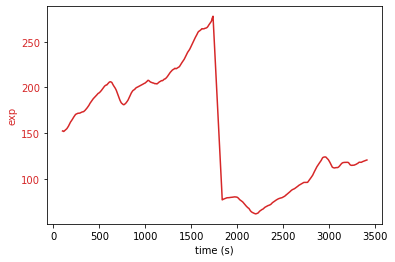

In [30]:
data1 = result.index
data2 = result['SMA_100']
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(data1,data2, color=color)
ax1.tick_params(axis='y', labelcolor=color)


plt.show()



<AxesSubplot:xlabel='hour'>

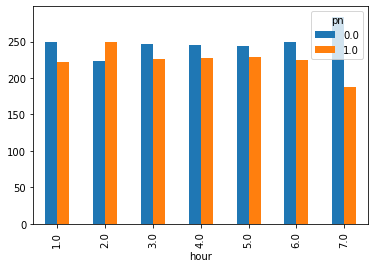

In [31]:
pd.crosstab(result['hour'], result['pn']).plot(kind='bar', stacked=False)

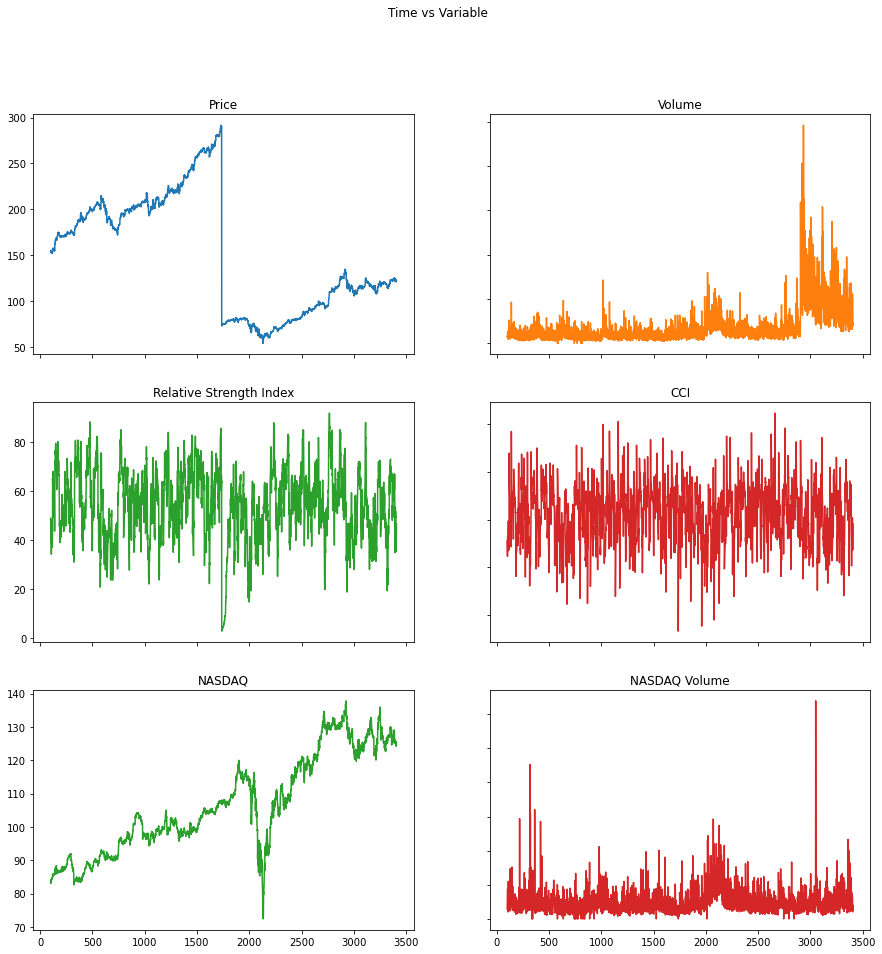

In [32]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2)
fig.suptitle('Time vs Variable')
ax1.plot(result.index, result['close'])
ax2.plot(result.index, result['volume'], 'tab:orange')
ax3.plot(result.index, result['RSI_14'], 'tab:green')
ax4.plot(result.index, result['CCI'], 'tab:red')
ax5.plot(result.index, result['close_etf'], 'tab:green')
ax6.plot(result.index, result['volume_etf'], 'tab:red')

ax1.set_title("Price")
ax2.set_title("Volume")
ax3.set_title("Relative Strength Index")
ax4.set_title("CCI")
ax5.set_title("NASDAQ")
ax6.set_title("NASDAQ Volume")


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_figheight(15)
fig.set_figwidth(15)


## Twitter

In [66]:
import tweepy
import re
from textblob import TextBlob
from wordcloud import WordCloud


In [67]:
consumer_key = "qDVcN5dTLAZN4OVY2MiRIfUqS"
consumer_secret = "5KY1kPH8XHSVvxcA6LJY5ky5bq3RL8uurfv2T9rqUxXMHLvs6u"  
access_token = "1335270791294771200-sXVhUS4UP740myytFrpOHGMDkguEPM"
access_token_secret = "e2BUGk7OxLknMjy8z7YKSMAmRxHgfKyc2CkJF8h8M8ctZ"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [68]:
text_query = ('AAPL')
count = 3000


tweets = tweepy.Cursor(api.search, q=text_query, lang="en", tweet_mode = 'extended').items(count)
# Pulling information from tweets iterable
tweets_list = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user, tweet.favorite_count,
                tweet.source, tweet.retweet_count, tweet.geo, tweet.favorite, tweet.destroy] for tweet in tweets]
# Creation of dataframe from tweets list
tweets_df = pd.DataFrame(tweets_list)


In [70]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink

    return text

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
       return  TextBlob(text).sentiment.polarity

In [71]:
df = pd.DataFrame()
df['cln_twt'] = tweets_df[2].apply(cleanTxt)
df['subj'] = tweets_df[2].apply(getSubjectivity)
df['polarity'] = tweets_df[2].apply(getPolarity)

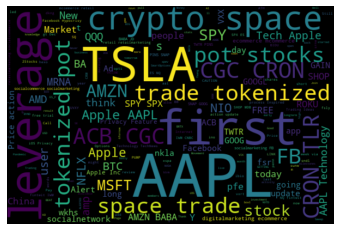

In [72]:
allWords = ' '.join([twts for twts in df['cln_twt']])
wordCloud = WordCloud(width=600, height=400, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

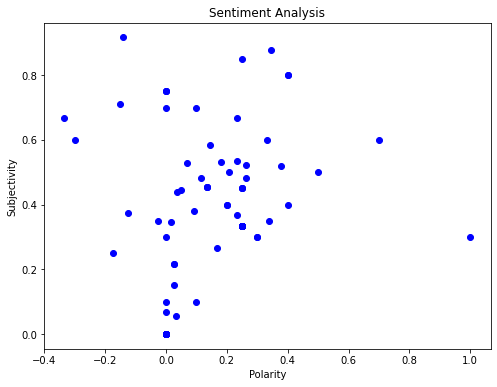

In [73]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, df.shape[0]):
      plt.scatter(df["polarity"][i], df["subj"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()